In [2]:
from keras.models import Model,Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Lambda, Input, UpSampling2D, BatchNormalization, Dropout, Flatten, Conv2D
from keras.optimizers import SGD
import os
from numpy import load
from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier

from keras.models import model_from_json
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
import pathlib
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
data_file = '/home/rayeh/Desktop/Project/data/dogs_vs_cats_photos.npy'
label_file = '/home/rayeh/Desktop/Project/data/dogs_vs_cats_labels.npy'
#選擇要解釋的影像(可選擇: 0~2499)===
image_id = 443

model_path = pathlib.Path().absolute()
print(model_path)


/home/rayeh/Desktop/Project/aix360/DL_final_AIX360


In [3]:
def load_AEmodel(model_json_file, model_wt_file):
    
    # read model json file
    with open(model_json_file, 'r') as f:
        model = model_from_json(f.read())
    
    # read model weights file
    model.load_weights(model_wt_file)
    
    return model

def load_cnnmodel(model_json_file, model_wt_file):
    
    with open(model_json_file, 'r') as f:
        model = model_from_json(f.read())
    
    # read model weights file
    model.load_weights(model_wt_file)
    
    return model

class CODEC:
    def __init__(self, img_size, num_channels, compress_mode=1, resize=None):

        self.compress_mode = compress_mode
        working_img_size = img_size

        encoder_model = Sequential()
        # resize input to a size easy for down-sampled
        if resize:
            encoder_model.add( Lambda(lambda image: tf.image.resize_images(image, (resize, resize)), 
            input_shape=(img_size, img_size, num_channels)))
        else:
            encoder_model.add(Convolution2D( 16, 3, strides=1,padding='same', input_shape=(img_size, img_size, num_channels)))
        
        BatchNormalization(axis=3)
        encoder_model.add(Activation("relu"))
        encoder_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
        working_img_size //= 2

        if compress_mode >=2:
            encoder_model.add(Convolution2D( 16, 3, strides=1,padding='same'))
            BatchNormalization(axis=3)
            encoder_model.add(Activation("relu"))
            encoder_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
            working_img_size //= 2

        if compress_mode >=3:
            encoder_model.add(Convolution2D( 16, 3, strides=1,padding='same'))
            BatchNormalization(axis=3)
            encoder_model.add(Activation("relu"))
            encoder_model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
            working_img_size //= 2

        encoder_model.add(Convolution2D(num_channels, 3, strides=1, padding='same'))
        BatchNormalization(axis=3)
        decoder_model = Sequential()
        decoder_model.add(encoder_model)

        if compress_mode >=3:
            working_img_size *= 2
            decoder_model.add(Convolution2D(16, 3, strides=1, padding='same'))
            BatchNormalization(axis=3)
            decoder_model.add(Activation("relu"))
            #decoder_model.add(Lambda(lambda image: tf.image.resize_images(image, (working_img_size, working_img_size))))
            decoder_model.add(UpSampling2D((2, 2), data_format='channels_last'))

        if compress_mode >=2:
            working_img_size *= 2
            decoder_model.add(Convolution2D(16, 3, strides=1, padding='same'))
            BatchNormalization(axis=3)
            decoder_model.add(Activation("relu"))
            #decoder_model.add(Lambda(lambda image: tf.image.resize_images(image, (working_img_size, working_img_size))))
            decoder_model.add(UpSampling2D((2, 2), data_format='channels_last'))

        working_img_size *= 2
        decoder_model.add(Convolution2D(16, 3, strides=1, padding='same'))
        BatchNormalization(axis=3)
        decoder_model.add(Activation("relu"))
        # decoder_model.add(Lambda(lambda image: tf.image.resize_images(image, (img_size, img_size))))
        decoder_model.add(UpSampling2D((2, 2), data_format='channels_last'))

        if resize:
            decoder_model.add(Lambda(lambda image: tf.image.resize_images(image, (img_size, img_size))))

        decoder_model.add(Convolution2D(num_channels, 3, strides=1, padding='same'))
        # decoder_model.add(Lambda(lambda image: K.clip(image, -clip_value, clip_value) ))


        print('Encoder model:')
        encoder_model.summary()

        print('Decoder model:')
        decoder_model.summary()

        self.encoder = encoder_model
        self.decoder = decoder_model


    def load_codec(self, weights_prefix):
        encoder_weight_filename = weights_prefix + "_encoder.h5"
        decoder_weight_filename = weights_prefix + "_decoder.h5"

        if not os.path.isfile(encoder_weight_filename):
            raise Exception("The file for encoder weights does not exist:{}".format(encoder_weight_filename))
        self.encoder.load_weights(encoder_weight_filename)

        if not os.path.isfile(decoder_weight_filename):
            raise Exception("The file for decoder weights does not exist:{}".format(decoder_weight_filename))
        self.decoder.load_weights(decoder_weight_filename)

        print("Encoder summaries")
        self.encoder.summary()

        _, encode_H, encode_W, numChannels = self.encoder.output_shape
        config = self.decoder.get_config()
        config2 = config[1::]
        config2[0]['config']['batch_input_shape'] = (None, encode_H, encode_W, numChannels)
        decoder_temp = Sequential.from_config(config2, custom_objects={"tf": tf})

        # set weights
        cnt = -1
        for l in self.decoder.layers:
            cnt += 1
            if cnt == 0:
                continue
            weights = l.get_weights()
            decoder_temp.layers[cnt - 1].set_weights(weights)

        self.decoder = decoder_temp
        print("Decoder summaries")
        self.decoder.summary()
class CatDog:
    def __init__(self):
        # load and confirm the shape
        data = load(data_file)
        labels = load(label_file)
        catg_labels = to_categorical(labels, num_classes=2)
        print(data.shape, labels.shape)
        
        VALIDATION_SIZE = 2500
        
        self.validation_data = data[:VALIDATION_SIZE, :, :, :]
        self.validation_labels = labels[:VALIDATION_SIZE]
        self.validation_catg_labels = catg_labels[:VALIDATION_SIZE]
        self.train_data = data[VALIDATION_SIZE:, :, :, :]
        self.train_labels = labels[VALIDATION_SIZE:]
        self.train_catg_labels = catg_labels[VALIDATION_SIZE:]

def train(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(2))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_catg_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_catg_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(f'{file_name}.h5')
    
    json_string = model.to_json()
    with open(f'{file_name}.json', 'w') as json_file:
        json_file.write(json_string)
    print(f'save model at {file_name}.')
    return model


In [4]:
#讀取data============================
if not os.path.isdir('model'):
    os.makedirs('model')
print('read dataset...')
cat_dog_data = CatDog()
print('Done')


read dataset...
(25000, 64, 64, 3) (25000,)
Done


In [5]:
# #訓練model or 讀取model============
# print('train model...')
# cnn_model = train(cat_dog_data, "model/catdog", [32, 32, 64, 64, 200, 200], num_epochs=20)
# print('Done')

# load model using its json and wt files
cnn_model = load_cnnmodel(os.path.join(model_path, 'model/catdog.json'), os.path.join(model_path, 'model/catdog.h5'))

# print model summary
cnn_model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
activation_33 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
activation_34 (Activation)   (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_35 (Activation)   (None, 28, 28, 64)      

In [6]:
#讀取Autoencoder model==============
codec = CODEC(img_size=64, num_channels=3, 
                compress_mode=1, resize=64)
codec.decoder.load_weights(os.path.join(model_path, 'model/catdog_1_decoder.h5'))
# print model summary
ae_model = codec.decoder 
ae_model.summary()

Encoder model:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 3)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 3)         84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________
Decoder model:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32, 32, 3)         84        
______

In [7]:
#建立解釋器=========================
mymodel = KerasClassifier(cnn_model)
explainer = CEMExplainer(mymodel)

(64, 64, 3)

class:  [0]
Predicted logits: [[ 1.9836096 -2.3378465]]


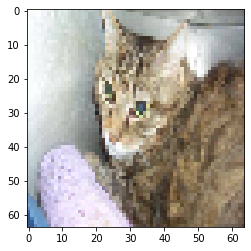

In [8]:
# choose an input image
input_image = cat_dog_data.validation_data[image_id]
print(input_image.shape)
plt.imshow(input_image+0.5)
print('class: ', mymodel.predict_classes(np.expand_dims(input_image, axis=0)))
print("Predicted logits:", mymodel.predict(np.expand_dims(input_image, axis=0)))

In [9]:
#search PN========================
arg_mode = "PN" # Find pertinent negative

arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term

arg_kappa = 0.9 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1.0 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) autoencoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 0.05 # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5

(adv_pn, delta_pn, info_pn) = explainer.explain_instance(np.expand_dims(input_image, axis=0), arg_mode, ae_model, arg_kappa, arg_b, 
                                            arg_max_iter, arg_init_const, arg_beta, arg_gamma, arg_alpha, arg_threshold, arg_offset)
print(info_pn)





Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

iter:0 const:[10.]
Loss_Overall:8479.9082, Loss_Attack:54.3110
Loss_L2Dist:3.8905, Loss_L1Dist:10.0453, AE_loss:8411.662109375
target_lab_score:2.0934, max_nontarget_lab_score:-2.4377

iter:500 const:[10.]
Loss_Overall:9284.8398, Loss_Attack:55.9147
Loss_L2Dist:5.9107, Loss_L1Dist:16.6318, AE_loss:9206.3828125
target_lab_score:2.1745, max_nontarget_lab_score:-2.5170

iter:0 const:[100.]
Loss_Overall:8798.1172, Loss_Attack:483.8647
Loss_L2Dist:3.9314, Loss_L1Dist:10.5648, AE_loss:8299.7568359375
target_lab_score:1.8002, max_nontarget_lab_score:-2.1385

iter:500 const:[100.]
Loss_Overall:10074.3877, Loss_Attack:567.6203
Loss_L2Dist:6.5074, Loss_L1Dist:16.8441, AE_loss:9483.416015625
target_lab_score:2.2213, max_nontarget_lab_score:-2.5549

iter:0 const:[1000.]
Loss_Overall:22415.1133, Loss_Attack:0.0000
Loss_L2Dis

In [10]:
#search PP=======================
arg_mode = "PP"  # Find pertinent positive
arg_beta = 0.1 # Controls sparsity of the solution (L1 loss)
(adv_pp, delta_pp, info_pp) = explainer.explain_instance(np.expand_dims(input_image, axis=0), arg_mode, ae_model, arg_kappa, arg_b, 
                                            arg_max_iter, arg_init_const, arg_beta, arg_gamma, arg_alpha, arg_threshold, arg_offset)
print(info_pp)

iter:0 const:[10.]
Loss_Overall:116896.4609, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:116896.4609375
target_lab_score:1.3774, max_nontarget_lab_score:-1.7192

iter:500 const:[10.]
Loss_Overall:116896.4609, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:116896.4609375
target_lab_score:1.3774, max_nontarget_lab_score:-1.7192

iter:0 const:[5.]
Loss_Overall:116896.4609, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:116896.4609375
target_lab_score:1.3774, max_nontarget_lab_score:-1.7192

iter:500 const:[5.]
Loss_Overall:116896.4609, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:116896.4609375
target_lab_score:1.3774, max_nontarget_lab_score:-1.7192

iter:0 const:[2.5]
Loss_Overall:116896.4609, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:116896.4609375
target_lab_score:1.3774, max_nontarget_lab_score:-1.7192

iter:500 const:[2.5]
Loss_Overall:116896.4609, Loss_Attack:0.0000
Loss_L2

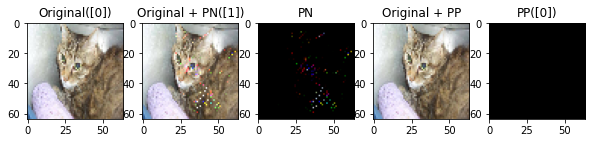

In [11]:
#plot PN and PP=================
fig0 = (input_image)+0.5

fig1 = np.clip((adv_pn[0])+0.5,0.,1.) 
fig2 = np.clip((fig1 - fig0),0.,1.) #rescaled delta_pn
fig3 = np.clip((adv_pp[0])+0.5, 0., 1.) 
fig4 = np.clip((delta_pp[0])+0.5,0.,1.)  #rescaled delta_pp

f, axarr = plt.subplots(1, 5, figsize=(10,10))
axarr[0].set_title("Original" + "(" + str(mymodel.predict_classes(np.expand_dims(input_image, axis=0))) + ")")
axarr[1].set_title("Original + PN" + "(" + str(mymodel.predict_classes(adv_pn)) + ")")
axarr[2].set_title("PN")
axarr[3].set_title("Original + PP")
axarr[4].set_title("PP" + "(" + str(mymodel.predict_classes(delta_pp)) + ")")

axarr[0].imshow(fig0)
axarr[1].imshow(fig1)
axarr[2].imshow(fig2)
axarr[3].imshow(fig3)
axarr[4].imshow(fig4)
plt.savefig(f'./output/aix_output_{image_id}.jpg')
plt.show()